In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import time

In [2]:
dst_o = cv2.imread("..\\data\\underwater.png")
dst_o = cv2.cvtColor(dst_o, cv2.COLOR_BGR2RGB) / 255.0

src_o = cv2.imread("..\\data\\fish.jpg")
src_o = cv2.cvtColor(src_o, cv2.COLOR_BGR2RGB) / 255.0
src_o = src_o[55:245, 115:315]

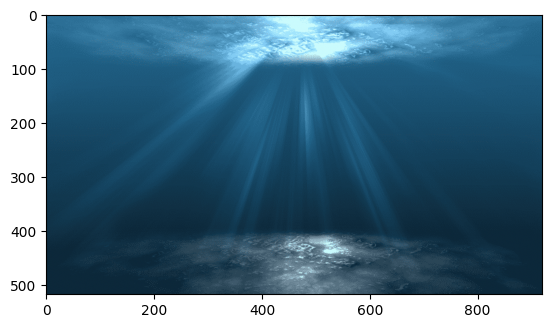

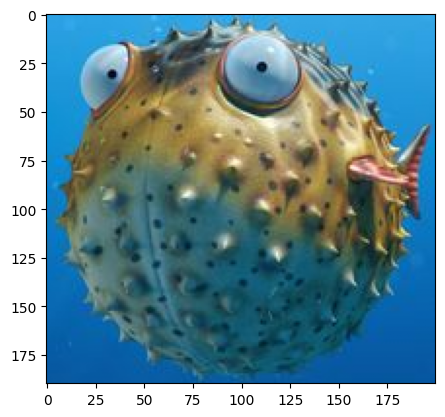

In [3]:
plt.imshow(dst_o)
plt.show()
plt.imshow(src_o)

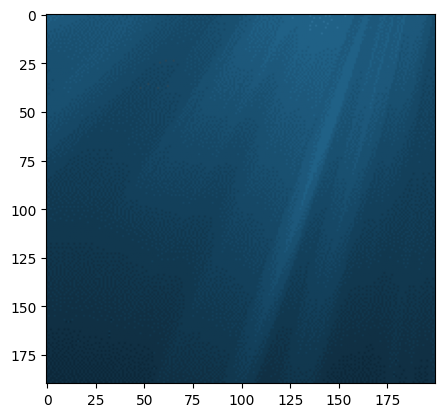

In [4]:
dst_c = dst_o[200:200+src_o.shape[0], 250:250+src_o.shape[1]]
plt.imshow(dst_c)

In [5]:
print(dst_c.shape)

(190, 200, 3)


# Fors...

In [190]:
def solve_fors(dst, src, iter, err, err_iter):
    for k in range(iter):
        copy = None
        if (k + 1) % err_iter == 0:
            copy = np.copy(dst)

        for i in range(1, dst.shape[0] - 1):
            for j in range(1, dst.shape[1] - 1):
                b = 4 * src[i, j] - (src[i + 1, j] + src[i - 1, j] + src[i, j + 1] + src[i, j - 1])
                d = -(dst[i + 1, j] + dst[i - 1, j] + dst[i, j + 1] + dst[i, j - 1])
                dst[i, j] = (b - d) / 4.0

        if (k + 1) % err_iter == 0:
            er = np.max(np.abs(copy - dst))
            print(k + 1, er)
            if er < err:
                break

25 0.005667148479709089
50 0.0027928247399260087
75 0.001810523079618008
100 0.0014178696364630303


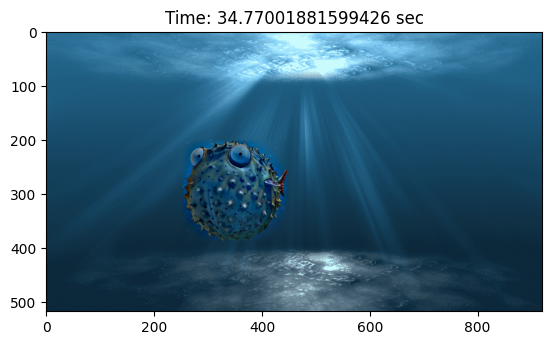

In [191]:
dst = np.copy(dst_c)
src = np.copy(src_o)

start = time.time()
solve_fors(dst, src, 100, 1e-7, 25)
end = time.time()

res = np.copy(dst_o)
res[200:200+src_o.shape[0], 250:250+src_o.shape[1]] = np.clip(cv2.resize(dst, (dst_c.shape[1], dst_c.shape[0])), 0, 1)

plt.figure()
plt.title(f"Time: {end - start} sec")
plt.imshow(res)

# Linalg

38000


Text(0.5, 1.0, 'spsolve --- Time: 0.9336738586425781 sec')

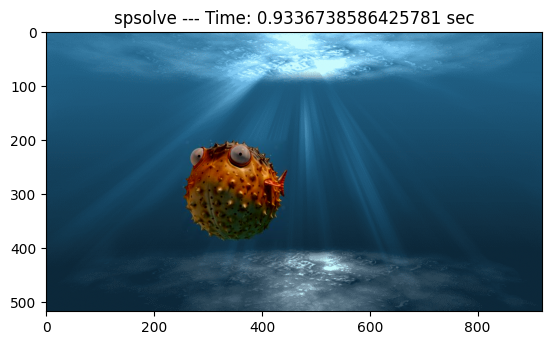

In [8]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

rsh = (dst_c.shape[0], dst_c.shape[1])

dim = rsh[0]*rsh[1]
print(dim)

data = []
row = []
col = []

h = rsh[0]
w = rsh[1]
for i in range(h):
    for j in range(w):
        r = i * w + j
        if i == 0 or j == 0 or i == (h - 1) or j == (w - 1):
            data.append(1)
            row.append(r)
            col.append(r)
            continue
        else:
            data.append(4)
            row.append(r)
            col.append(r)

        if i > 0:
            data.append(-1)
            row.append(r)
            col.append(r - w)

        if i < h - 1:
            data.append(-1)
            row.append(r)
            col.append(r + w)

        if j > 0:
            data.append(-1)
            row.append(r)
            col.append(r - 1)

        if j < w - 1:
            data.append(-1)
            row.append(r)
            col.append(r + 1)


A = csr_matrix((data, (row, col)), shape=(dim, dim))

B = np.empty((dim, 3))

for i in range(h):
    for j in range(w):
        if i == 0 or j == 0 or i == (h - 1) or j == (w - 1):
            b = dst_c[i, j]
        else:
            b = 4 * src_o[i, j] - (src_o[i + 1, j] + src_o[i - 1, j] + src_o[i, j + 1] + src_o[i, j - 1])

        B[i * w + j] = b

start = time.time()
r = spsolve(A, B[:, 0]).reshape((h, w))
g = spsolve(A, B[:, 1]).reshape((h, w))
b = spsolve(A, B[:, 2]).reshape((h, w))
end = time.time()

rgb = cv2.merge([r, g, b])

res = np.copy(dst_o)
res[200:200+src_o.shape[0], 250:250+src_o.shape[1]] = np.clip(cv2.resize(rgb, (dst_c.shape[1], dst_c.shape[0])), 0, 1)
plt.imshow(res)
plt.title(f"spsolve --- Time: {end - start} sec")


# Filter2D

In [183]:

def solve_simple(dst, src, iter, err, err_iter):
    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) / 4.0
    kernel_D = np.array([[0, -1, 0], [-1, 0, -1], [0, -1, 0]]) / 4.0

    B = cv2.filter2D(src, -1, kernel, borderType=cv2.BORDER_REFLECT)
    for k in range(iter):
        copy = None
        if (k + 1) % err_iter == 0:
            copy = np.copy(dst)

        U = cv2.filter2D(dst, -1, kernel_D, borderType=cv2.BORDER_REFLECT)
        dst[1:-1, 1:-1, :] = (B - U)[1:-1, 1:-1, :]

        if (k + 1) % err_iter == 0:
            er = np.max(np.abs(copy - dst))
            print(k + 1, er)
            if er < err:
                break

def solve_advance(dst, src, iter, err, err_iter):
    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) / 4.0
    kernel_D = np.array([[0, -1, 0], [-1, 0, -1], [0, -1, 0]]) / 4.0

    B = cv2.filter2D(src, -1, kernel, borderType=cv2.BORDER_REFLECT)
    for k in range(iter):
        copy = None
        if (k + 1) % err_iter == 0:
            copy = np.copy(dst)

        U = cv2.filter2D(dst, -1, kernel_D, borderType=cv2.BORDER_REFLECT)
        D = B - U
        dst[1:-1, 1:-1][::2, 1::2] = D[1:-1, 1:-1][::2, 1::2]
        dst[1:-1, 1:-1][1::2, ::2] = D[1:-1, 1:-1][1::2, ::2]

        U = cv2.filter2D(dst, -1, kernel_D, borderType=cv2.BORDER_REFLECT)
        D = B - U
        dst[1:-1, 1:-1][::2, ::2]   = D[1:-1, 1:-1][::2, ::2]
        dst[1:-1, 1:-1][1::2, 1::2] = D[1:-1, 1:-1][1::2, 1::2]

        if (k + 1) % err_iter == 0:
            er = np.max(np.abs(copy - dst))
            print(k + 1, er)
            if er < err:
                break

def solve_advance_2(dst, src, iter, err, err_iter):
    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]]) / 4.0
    kernel_X = np.array([[-1, 0, -1], [0, 0, 0], [-1, 0, -1]]) / 4.0
    kernel_D = np.array([[0, -1, 0], [-1, 0, -1], [0, -1, 0]]) / 4.0

    B = cv2.filter2D(src, -1, kernel, borderType=cv2.BORDER_REFLECT)
    for k in range(iter):
        copy = None
        if (k + 1) % err_iter == 0:
            copy = np.copy(dst)

        U = cv2.filter2D(dst, -1, kernel_X, borderType=cv2.BORDER_REFLECT)
        D = B - U
        dst[1:-1, 1:-1] = D[1:-1, 1:-1]

        U = cv2.filter2D(dst, -1, kernel_D, borderType=cv2.BORDER_REFLECT)
        D = B - U
        dst[1:-1, 1:-1] = D[1:-1, 1:-1]

        if (k + 1) % err_iter == 0:
            er = np.max(np.abs(copy - dst))
            print(k + 1, er)
            if er < err:
                break

1000 0.0012290521327993353
2000 0.0006944528398667438
3000 0.0004745682961259101
4000 0.00033434269276821915
5000 0.00024360881279448382
6000 0.00018199314341610373
7000 0.0001383454440945231
8000 0.00010650635287906551
9000 8.285184968286063e-05


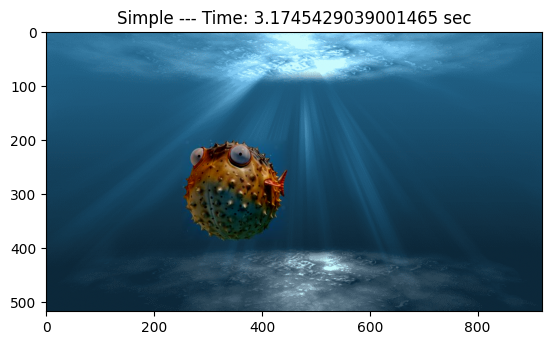

In [118]:
dst = np.copy(dst_c)
src = np.copy(src_o)

start = time.time()
solve_simple(dst, src, 100000, 1e-4, 1000)
end = time.time()

res = np.copy(dst_o)
res[200:200+src_o.shape[0], 250:250+src_o.shape[1]] = np.clip(cv2.resize(dst, (dst_c.shape[1], dst_c.shape[0])), 0, 1)

plt.figure()
plt.title(f"Simple --- Time: {end - start} sec")
plt.imshow(res)

1000 0.0001581419778535348
2000 8.812167140029303e-05
3000 6.972331792823305e-05
4000 5.553064801908092e-05
5000 4.3206510756704786e-05


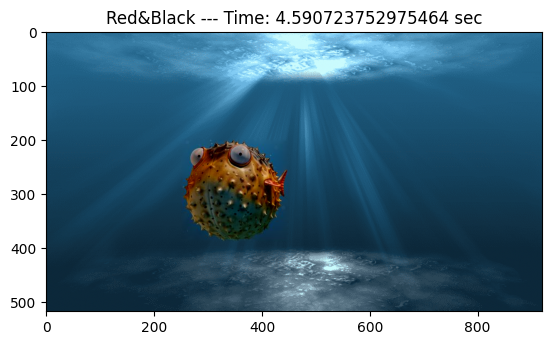

In [197]:
dst = np.copy(dst_c)
src = np.copy(src_o)

start = time.time()
solve_advance(dst, src, 100000, 0.5e-4, 1000)
end = time.time()

res = np.copy(dst_o)
res[200:200+src_o.shape[0], 250:250+src_o.shape[1]] = np.clip(cv2.resize(dst, (dst_c.shape[1], dst_c.shape[0])), 0, 1)

plt.figure()
plt.title(f"Red&Black --- Time: {end - start} sec")
plt.imshow(res)

1000 0.0005414130288940999
2000 0.00021928201757009935
3000 0.00010510982384005774
4000 5.550307835774926e-05
5000 3.21778796133626e-05


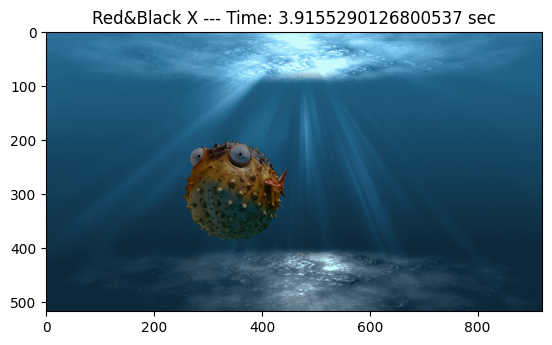

In [184]:
dst = np.copy(dst_c)
src = np.copy(src_o)

start = time.time()
solve_advance_2(dst, src, 100000, 0.5e-4, 1000)
end = time.time()

res = np.copy(dst_o)
res[200:200+src_o.shape[0], 250:250+src_o.shape[1]] = np.clip(cv2.resize(dst, (dst_c.shape[1], dst_c.shape[0])), 0, 1)

plt.figure()
plt.title(f"Red&Black X --- Time: {end - start} sec")
plt.imshow(res)

500 0.00044560007650010225
1000 0.0001314904106633763
1500 3.856262958693013e-05
100 0.00010561444568416012
200 3.5279913566277354e-05


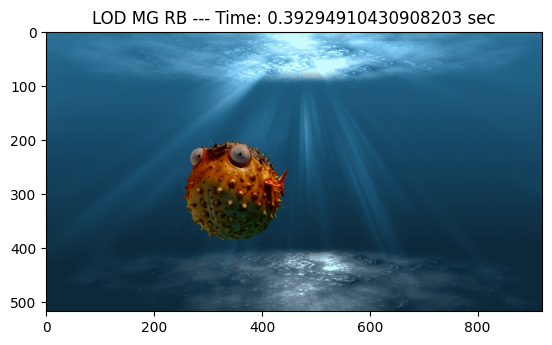

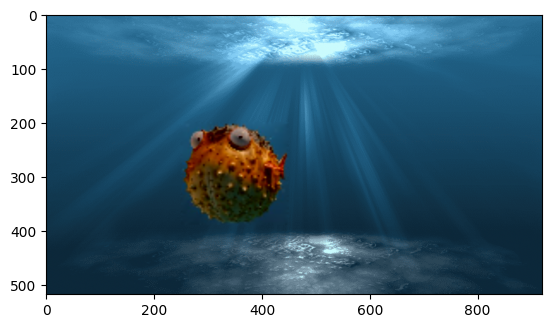

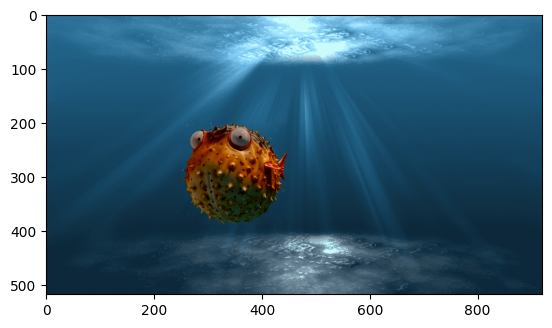

In [191]:
dst = np.copy(dst_c)
src = np.copy(src_o)

dst = np.copy(dst_c)
src = np.copy(src_o)

start = time.time()

dst_l0 = dst
src_l0 = src

dst_l1 = cv2.resize(dst_l0, (dst_l0.shape[0] // 3, dst_l0.shape[1] // 3))
src_l1 = cv2.resize(src_l0, (src_l0.shape[0] // 3, src_l0.shape[1] // 3))

solve_advance(dst_l1, src_l1, 100000, 1e-4, 500)
dst_l0 = cv2.resize(dst_l1, (dst_l0.shape[1], dst_l0.shape[0]))

solve_advance(dst_l0, src_l0, 100000, 1e-4, 100)

end = time.time()

res = np.copy(dst_o)
res[200:200+src_o.shape[0], 250:250+src_o.shape[1]] = np.clip(dst_l0, 0, 1)

plt.figure()
plt.title(f"LOD MG RB --- Time: {end - start} sec")
plt.imshow(res)
plt.show()

ddd = [dst_l1, dst_l0]
for d in ddd:
    res = np.copy(dst_o)
    res[200:200+src_o.shape[0], 250:250+src_o.shape[1]] = np.clip(cv2.resize(d, (dst_c.shape[1], dst_c.shape[0])), 0, 1)
    plt.imshow(res)
    plt.show()

500 0.00025722681384995894
1000 4.0828799699299534e-05
100 6.659305608329447e-05


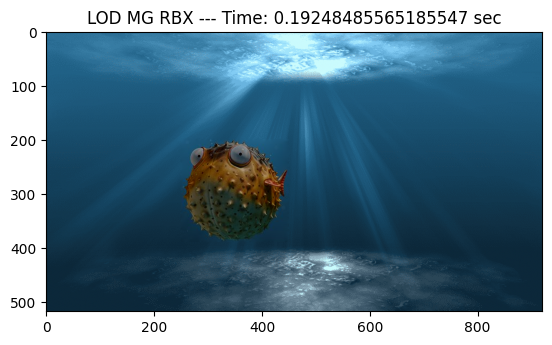

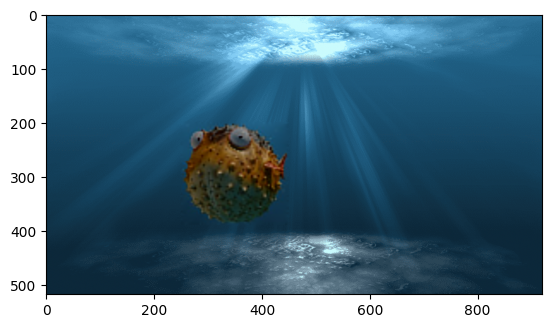

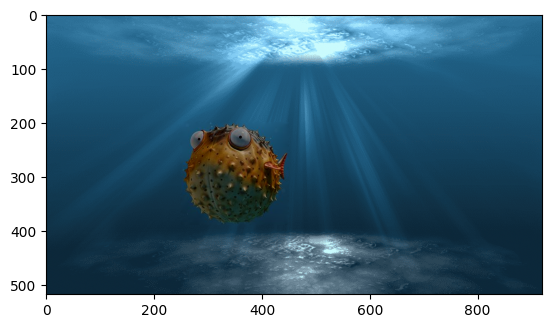

In [198]:
dst = np.copy(dst_c)
src = np.copy(src_o)

dst = np.copy(dst_c)
src = np.copy(src_o)

start = time.time()

dst_l0 = dst
src_l0 = src

dst_l1 = cv2.resize(dst_l0, (dst_l0.shape[0] // 3, dst_l0.shape[1] // 3))
src_l1 = cv2.resize(src_l0, (src_l0.shape[0] // 3, src_l0.shape[1] // 3))

solve_advance_2(dst_l1, src_l1, 100000, 1e-4, 500)
dst_l0 = cv2.resize(dst_l1, (dst_l0.shape[1], dst_l0.shape[0]))

solve_advance_2(dst_l0, src_l0, 100000, 1e-4, 100)

end = time.time()

res = np.copy(dst_o)
res[200:200+src_o.shape[0], 250:250+src_o.shape[1]] = np.clip(dst_l0, 0, 1)

plt.figure()
plt.title(f"LOD MG RBX --- Time: {end - start} sec")
plt.imshow(res)
plt.show()

ddd = [dst_l1, dst_l0]
for d in ddd:
    res = np.copy(dst_o)
    res[200:200+src_o.shape[0], 250:250+src_o.shape[1]] = np.clip(cv2.resize(d, (dst_c.shape[1], dst_c.shape[0])), 0, 1)
    plt.imshow(res)
    plt.show()